# Hyper-parameter tuning – Friedman #3 Dataset  
This notebook finds the best parameters for:

* **Bagging** RandomForestRegressor  
* **Boosting** XGBRegressor  
* **Stack meta learner** Ridge α in the RF+XGB+OLS stack

Results are saved to `configs/` folder as yaml files.

## Setup & Imports

In [1]:
from joblib import parallel_backend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.model_selection import (
    RepeatedKFold,
    KFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.visualization import plot_optimization_history

from bagging_boosting_stacking_study.constants import SEED
from bagging_boosting_stacking_study.data.loaders import load_dataset
from bagging_boosting_stacking_study.configs import save_params, load_params

DATASET_NAME = "energy_efficiency"

In [2]:
# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

## Load Clean Dataset

In [3]:
df = load_dataset(DATASET_NAME, raw=False)

### train test split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)

In [6]:
train_df.shape

(691, 13)

In [7]:
test_df.shape

(77, 13)

## Bagging

### pipeline



### hyper-parameter tuning

In [9]:
# Split X and y (here X is a DataFrame)
y = train_df["target"].values
X = train_df.drop(columns="target")
n_features_total = X.shape[1]

# Cross-validation strategy: 10-fold, repeated three times
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)


# Objective function for Optuna
def objective(trial):
    # Hyper-parameter search space
    # (a) Forest size
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 400])

    # (b) Tree depth
    max_depth = trial.suggest_int("max_depth", 4, 12, step=2)

    # (c) Regularisation
    min_samples_split = trial.suggest_int("min_samples_split", 2, 14, step=2)
    min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 6)

    # (d) Feature subsampling
    max_features = trial.suggest_int("max_features", 2, n_features_total)

    # (e) Row subsampling
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_samples = (
        trial.suggest_float("max_samples", 0.6, 1.0, step=0.1) if bootstrap else None
    )

    # (f) Impurity & pruning
    criterion  = trial.suggest_categorical("criterion", ["squared_error", "absolute_error"])
    ccp_alpha  = trial.suggest_float("ccp_alpha", 1e-6, 1e-3, log=True)
    oob_score  = bootstrap and trial.suggest_categorical("oob_score", [True, False])

    # Model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        max_samples=max_samples,
        criterion=criterion,
        ccp_alpha=ccp_alpha,
        oob_score=oob_score,
        n_jobs=-1,
        random_state=SEED,
    )

    # CV evaluation
    # NOTE: scikit-learn returns negative RMSE so I negate “neg_root_mean_squared_error”
    # again to get a positive value to minimise.
    rmse = -cross_val_score(
        rf, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the study
study_rf = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),  # reproducible search
    pruner=HyperbandPruner(),  # aggressive early stopping
    study_name=f"RF_{DATASET_NAME}",
)

# Robust search: either n_trials or timeout
study_rf.optimize(objective, n_trials=200, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

# Inspect the result
print("Best RMSE :", study_rf.best_value)
print("Best parameters:", study_rf.best_params)

[I 2025-05-28 00:10:42,620] A new study created in memory with name: RF_energy_efficiency


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-28 00:10:45,440] Trial 0 finished with value: 0.7675736728089853 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 3, 'bootstrap': False, 'criterion': 'squared_error', 'ccp_alpha': 1.5186021387883792e-06}. Best is trial 0 with value: 0.7675736728089853.
[I 2025-05-28 00:10:46,970] Trial 1 finished with value: 0.7367866553808622 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 12, 'bootstrap': True, 'max_samples': 0.8, 'criterion': 'squared_error', 'ccp_alpha': 1.339053311643714e-06, 'oob_score': True}. Best is trial 1 with value: 0.7367866553808622.
[I 2025-05-28 00:10:47,191] Trial 2 finished with value: 0.839356228674893 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 9, 'bootstrap': True, 'max_samples': 0.6, 'criterion': 'squared_error', 'ccp_alpha': 1.0555723724907324e-

In [10]:
fig = plot_optimization_history(study_rf)
fig.show()

In [11]:
print("Best RMSE :", study_rf.best_value)

Best RMSE : 0.47663141024343536


In [12]:
study_rf.best_params

{'n_estimators': 200,
 'max_depth': 8,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 12,
 'bootstrap': True,
 'max_samples': 1.0,
 'criterion': 'absolute_error',
 'ccp_alpha': 1.4156153920779745e-05,
 'oob_score': False}

In [13]:
# Save best params to .yaml
save_params(DATASET_NAME, "rf", study_rf.best_value, study_rf.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\energy_efficiency_rf.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/energy_efficiency_rf.yaml')

In [14]:
best_rf_params = study_rf.best_params.copy()

if "cap_depth" in best_rf_params:            
    cap_flag  = best_rf_params.pop("cap_depth")
    max_depth = best_rf_params.pop("max_depth", None)
    best_rf_params["max_depth"] = max_depth if cap_flag else None

best_rf_params.update({"random_state": SEED, "n_jobs": -1})

if not best_rf_params.get("bootstrap", False):
    best_rf_params["max_samples"] = None
    best_rf_params["oob_score"]  = False

rf_final = RandomForestRegressor(**best_rf_params)
rf_final.fit(train_df.drop(columns="target"), train_df["target"])

RandomForestRegressor(ccp_alpha=1.4156153920779745e-05,
                      criterion='absolute_error', max_depth=8, max_features=12,
                      max_samples=1.0, n_estimators=200, n_jobs=-1,
                      random_state=333)

## Boosting

In [15]:
# Split X and y
y = train_df["target"].values
X = train_df.drop(columns="target")

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)


# Objective function
def objective(trial):
    # Search space
    # (a) Ensemble size
    n_estimators = trial.suggest_int("n_estimators", 100, 700, step=100)

    # (b) Learning rate
    learning_rate = trial.suggest_float("learning_rate", 0.02, 0.3, log=True)

    # (c) Growth strategy
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if grow_policy == "depthwise":
        max_depth  = trial.suggest_int("max_depth", 3, 10)
        max_leaves = None
    else:                                    # lossguide = leaf-wise
        max_depth  = 0                       # ignored
        max_leaves = trial.suggest_int("max_leaves", 32, 256, step=32)

    # (d) Child-weight & sampling
    min_child_weight = trial.suggest_float("min_child_weight", 0.5, 8.0, log=True)
    subsample        = trial.suggest_float("subsample", 0.7, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1)

    # (e) Regularisation
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 20.0, log=True)
    reg_alpha  = trial.suggest_float("reg_alpha", 0.0, 8.0)
    gamma      = trial.suggest_float("gamma", 0.0, 4.0)

    # (f) Safety knob (rarely triggered in regression)
    max_delta_step = trial.suggest_int("max_delta_step", 0, 4)

    # Build the Pipeline with XGB model
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        max_delta_step=max_delta_step,
        grow_policy=grow_policy,
        objective="reg:squarederror",
        tree_method="hist",
        random_state=SEED,
        n_jobs=-1,
    )

    # CV evaluation (neg RMSE -> minimise RMSE)
    rmse = -cross_val_score(
        xgb, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the Optuna study
study_xgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=HyperbandPruner(),  # stops weak configs early
    study_name=f"XGB_{DATASET_NAME}",
)

study_xgb.optimize(objective, n_trials=300, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

print("Best RMSE :", study_xgb.best_value)
print("Best parameters:", study_xgb.best_params)

[I 2025-05-28 00:16:03,105] A new study created in memory with name: XGB_energy_efficiency


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-05-28 00:16:04,329] Trial 0 finished with value: 0.5912391139965036 and parameters: {'n_estimators': 400, 'learning_rate': 0.14399339620465235, 'grow_policy': 'lossguide', 'max_leaves': 96, 'min_child_weight': 0.571654219555205, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_lambda': 0.011362843279178395, 'reg_alpha': 6.987914835670487, 'gamma': 0.20644655721099614, 'max_delta_step': 0}. Best is trial 0 with value: 0.5912391139965036.
[I 2025-05-28 00:16:05,119] Trial 1 finished with value: 0.5172870336994266 and parameters: {'n_estimators': 200, 'learning_rate': 0.03472152866609779, 'grow_policy': 'lossguide', 'max_leaves': 256, 'min_child_weight': 1.8247023204796717, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 1.3301844399905502, 'reg_alpha': 3.8738293963385972, 'gamma': 0.5074441351777752, 'max_delta_step': 0}. Best is trial 1 with value: 0.5172870336994266.
[I 2025-05-28 00:16:05,172] Trial 2 finished with value: 0.8784011691339353 and parameters: {'n_estimato

In [16]:
fig = plot_optimization_history(study_xgb)
fig.show()

In [17]:
print("Best RMSE:", study_xgb.best_value)

Best RMSE: 0.4462434839631094


In [18]:
study_xgb.best_params

{'n_estimators': 700,
 'learning_rate': 0.06840374698062937,
 'grow_policy': 'depthwise',
 'max_depth': 3,
 'min_child_weight': 0.5792802913154267,
 'subsample': 0.8999999999999999,
 'colsample_bytree': 0.8,
 'reg_lambda': 0.0021010118449342036,
 'reg_alpha': 0.7041071149377156,
 'gamma': 0.07684576774782564,
 'max_delta_step': 4}

In [19]:
# Save best params to .yaml
save_params(DATASET_NAME, "xgb", study_xgb.best_value, study_xgb.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\energy_efficiency_xgb.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/energy_efficiency_xgb.yaml')

In [20]:
best_params = study_xgb.best_params.copy()

if best_params["grow_policy"] == "depthwise":
    best_params.pop("max_leaves", None)  # not used in depthwise mode
else:  # 'lossguide'
    best_params["max_depth"] = 0  # XGB uses leaves cap instead

best_params.update(
    {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "random_state": SEED,
        "n_jobs": -1,
    }
)

# # drop any keys XGB doesn't recognise
# allowed_keys = XGBRegressor().get_params().keys()
# best_params  = {k: v for k, v in best_params.items() if k in allowed_keys}

# final fit on the full training dataset
xgb_final = XGBRegressor(**best_params)
xgb_final.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.07684576774782564,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, learning_rate=0.06840374698062937,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=4, max_depth=3, max_leaves=None,
             min_child_weight=0.5792802913154267, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=-1, num_parallel_tree=None, ...)

## Stacking

In [21]:
y = train_df["target"].values
X = train_df.drop(columns="target")  # keep DF for column names

# Base Learners
# Base-learner: Random-Forest
rf_best = load_params(dataset=DATASET_NAME, model="rf")["params"].copy()

# clean-up depth flags that may still be present
cap_flag = rf_best.pop("cap_depth", None)
if cap_flag is not None:  # old key might not exist any more
    rf_best["max_depth"] = rf_best.pop("max_depth", None) if cap_flag else None

# make bootstrap-side params explicit
if not rf_best.get("bootstrap", False):
    rf_best["max_samples"] = None
    rf_best["oob_score"] = False

rf_best.update(dict(random_state=SEED, n_jobs=-1))
rf_pipeline = Pipeline([("rf", RandomForestRegressor(**rf_best))])

# Base-learner: XGBoost
xgb_best = load_params(dataset=DATASET_NAME, model="xgb")["params"].copy()

# keep depth/leaf keys consistent with grow_policy
if xgb_best.get("grow_policy", "depthwise") == "depthwise":
    xgb_best.pop("max_leaves", None)
else:  # lossguide
    xgb_best["max_depth"] = 0  # XGB uses leaf cap instead

xgb_best.update(
    dict(objective="reg:squarederror", tree_method="hist", random_state=SEED, n_jobs=-1)
)
xgb_pipeline = Pipeline([("xgb", XGBRegressor(**xgb_best))])

# Base-learner: OLS with scaling
ols_pipeline = Pipeline(
    steps=[
        ("sc", StandardScaler()),
        ("ols", LinearRegression(n_jobs=-1)),
    ]
)

base_estimators = [
    ("rf", rf_pipeline),
    ("xgb", xgb_pipeline),
    ("ols", ols_pipeline),
]

# Out-of-fold predictions to feed Ridge meta-learner
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

preds = []
with parallel_backend("loky"):  # honours each model's n_jobs
    for name, est in tqdm(base_estimators, desc="OOF learners"):
        oof = cross_val_predict(est, X, y, cv=cv, n_jobs=-1, verbose=0)
        preds.append(oof)

X_meta = np.column_stack(preds)

# RidgeCV as meta-learner
alphas = np.concatenate(([0.0], np.logspace(-8, 2, 500)))
ridge_cv = RidgeCV(
    alphas=alphas, cv=cv, scoring="neg_root_mean_squared_error", store_cv_results=False
).fit(X_meta, y)

best_alpha = ridge_cv.alpha_
best_rmse = np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))

print(f"Chosen alpha: {best_alpha:.4g}")
print(f"OOF RMSE: {best_rmse:.5f}")

OOF learners:   0%|          | 0/3 [00:00<?, ?it/s]

Chosen alpha: 3.607
OOF RMSE: 0.44265


In [22]:
print(f"Best RMSE: {np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))}")

Best RMSE: 0.442650900689354


In [23]:
print(f"Best lambda (alpha): {ridge_cv.alpha_}")

Best lambda (alpha): 3.6067349515740315


In [24]:
# Save best params to .yaml
save_params(
    dataset=DATASET_NAME, 
    model="stack", 
    metric=np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta))), 
    params={"alpha": float(ridge_cv.alpha_)}
)

Params saved to src\bagging_boosting_stacking_study\configs\energy_efficiency_stack.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/energy_efficiency_stack.yaml')

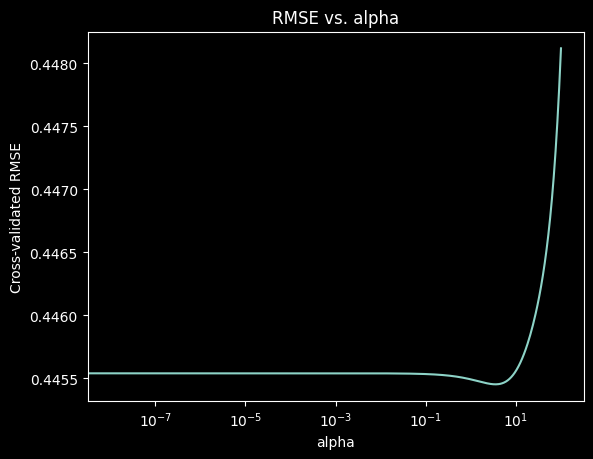

In [25]:
rmses = []
for a in alphas:
    scores = cross_val_score(
        Ridge(alpha=a),
        X_meta,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    rmses.append(-scores.mean())

plt.figure()
plt.xscale("log")
plt.plot(alphas, rmses)
plt.xlabel("alpha")
plt.ylabel("Cross-validated RMSE")
plt.title("RMSE vs. alpha")
plt.show()

In [26]:
alphas[np.argmin(rmses)]

np.float64(3.6067349515740315)

In [27]:
best_alpha = ridge_cv.alpha_
meta_final = Pipeline(
    steps=[
        ("sc", StandardScaler()),
        (
            "ridge",
            Ridge(
                alpha=best_alpha,
                random_state=SEED,
            ),
        ),
    ]
)

# full stacking model
stack_final = StackingRegressor(
    estimators=base_estimators,  # rf_pipeline, xgb_pipeline, ols_pipeline
    final_estimator=meta_final,
    cv=cv,  # same 10-fold KFold
    passthrough=False,
    n_jobs=-1,
)
stack_final.fit(X, y)

StackingRegressor(cv=KFold(n_splits=5, random_state=333, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('rf',
                                                RandomForestRegressor(ccp_alpha=1.4156153920779745e-05,
                                                                      criterion='absolute_error',
                                                                      max_depth=8,
                                                                      max_features=12,
                                                                      max_samples=1.0,
                                                                      n_estimators=200,
                                                                      n_jobs=-1,
                                                                      random_state=333))])),
                              ('xgb',
                               Pipeline(steps=[('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster...
                                                             min_child_weight=0.5792802913154267,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=700,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None, ...))])),
                              ('ols',
                               Pipeline(steps=[('sc', StandardScaler()),
                                               ('ols',
                                                LinearRegression(n_jobs=-1))]))],
                  final_estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                  ('ridge',
                                                   Ridge(alpha=np.float64(3.6067349515740315),
                                                         random_state=333))]),
                  n_jobs=-1)